In [4]:
import os
import sys
import pickle
import warnings 
import string

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import AgglomerativeClustering   

from utils import gen_clustering_metadata, extract_clustering_results, do_poisson_clustering,\
      do_poisson_clustering_improved, two_sample_test, nice_string_output, add_text_to_ax
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

#### TODO:
0) Lav noget cleanup af funktioner (indbyg mean i extract og væk med std for cluster size etc)
01) Måske er et hist af Nfraction og clustersize med sammenligning og kolmogrov et renere resultat
1) Gør stat.-analysen præsenterbar
2) Indsæt .225 when done
3) Overvej Nmin. Er 3 OK?
4) Prøv at smide noise ind på N i Poisson og se forskel(eller initaliser præcist ud fra N i hvert frame)
5) Efter proof of concept, byg det ind i infrastrukturen og lav analysen på tværs af L

In [2]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

In [3]:
Ncmin = 3
min_act_idx_l = 1 # we dont include 19 for convenience and lack of defects

cl_arr_l, cl_mean_l, cl_std_l = extract_clustering_results(Nframes_l, act_l, act_dir_l, len(Nexp_l), Ncmin=Ncmin, save=False)
cl_arr_vl, cl_mean_vl, cl_std_vl = extract_clustering_results(Nframes_vl, act_vl, act_dir_vl, len(Nexp_vl), Ncmin=Ncmin, save=False)

frame_idx_cutoff = Nframes_l
cl_arr_vl_orig = cl_arr_vl.astype(np.float64)
cl_arr_vl = cl_arr_vl[-frame_idx_cutoff:]
Nframes_vl = frame_idx_cutoff

cl_mean = np.concatenate([cl_mean_vl, cl_mean_l[:,min_act_idx_l:]], axis=1)
cl_std = np.concatenate([cl_std_vl, cl_std_l[:,min_act_idx_l:]], axis=1)

act_list = np.unique(np.concatenate([act_vl, act_l[min_act_idx_l:]]))

Below, Poisson simulation is done whilst allowing Ndef to vary for each activity, and also allowing for doing a greater number of Poisson simulation that we have defects frames.

In [13]:
x = np.random.randint(0, 4, size=(10,2))
#mask_degenerate = ~()
np.unique(x, return_index=True, axis=0), x

((array([[0, 1],
         [0, 2],
         [1, 0],
         [1, 2],
         [2, 1],
         [2, 3],
         [3, 0]]),
  array([9, 2, 7, 5, 0, 3, 1], dtype=int64)),
 array([[2, 1],
        [3, 0],
        [0, 2],
        [2, 3],
        [0, 2],
        [1, 2],
        [2, 3],
        [1, 0],
        [2, 1],
        [0, 1]]))

In [21]:

def do_poisson_clustering_improved(def_arr, L, Ntrial, Ncmin = 2, \
    method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=33), \
    grid_kwargs = dict(use_grid = False)):
    """
    This function is an improved version of do_poisson_clustering. It allows for Ndefects to vary for each activity,
    and also allows for Ntrial to be bigger than the number of defect entries in def_arr. For each run, it randomly selects
    Ndefects from the given column in def_arr, simulates points uniformly and performs the clustering.

    Parameters:
        def_arr: array of defect entries for each activity. Format (Ndefect_entries, Nactivities)
        L: length of the square box
        Ntrial: number of trials per column in def_arr
        Ncmin: minimum number of defects in a cluster
        method_kwargs: dictionary of arguments for AgglomerativeClustering

    Returns: cluster_arr, cl_mean, cl_std

    """
    
    _, Nact = def_arr.shape
    cluster_arr = np.nan * np.zeros([4, Nact, Ntrial])

    cst = AgglomerativeClustering(**method_kwargs)

    for i in range(Nact):

        Nlist = np.random.choice(def_arr[:, i], size = Ntrial)
        

        for j in range(Ntrial):

           # N = np.random.choice(def_arr[:, i], size = 1)[0]
            N = Nlist[j]

            if np.isnan(N):
                continue

            # generate points
            N = int(N)
            if grid_kwargs['use_grid']:
                defect_positions = (np.random.randint(0, int(L/2), size = (N, 2), dtype=int) * 2).astype(float)
            else:
                defect_positions = np.random.rand(N, 2) * L   

            # cluster
            labels = cst.fit_predict(defect_positions)

            counts = np.unique(labels, return_counts=True)[1]

            # Only count clusters with more than Ncmin defects
            mask = (counts >= Ncmin)
            counts_above_min = counts[mask]

            # store the total number of defects
            cluster_arr[0, i, j] = N

            # store the fraction of clustered defects
            cluster_arr[1, i, j] = counts_above_min.sum() / N

            # store the number of clusters
            cluster_arr[2, i, j] = len(counts_above_min)
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                # store the average cluster size
                cluster_arr[3, i, j] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Ntrial)

    return cluster_arr, cl_mean, cl_std

In [25]:
L = 512
Rmax = 33
Ntrial = Nframes_l #* len(Nexp_l)

method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

def_arr = np.concatenate([cl_arr_vl[-Nframes_l:, 0, :, :], cl_arr_l[:, 0, min_act_idx_l:, :]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

Ntrial *= 10
grid_kwargs = dict(use_grid = True)
cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering_improved(def_arr_reshaped, L, Ntrial=Ntrial,\
                                                                       Ncmin = Ncmin, method_kwargs = method_kwargs, grid_kwargs = grid_kwargs)

In [11]:
cl_mean_uni[0], cl_mean_uni[1]

(array([  5.16327668,  10.09573273,  12.47925   ,  21.1695    ,
         37.38875   , 145.246     , 256.7825    , 323.3305    ,
        370.0835    , 416.72075   ]),
 array([0.00234745, 0.0089015 , 0.01508323, 0.05131069, 0.12840679,
        0.65371937, 0.9033489 , 0.95568344, 0.97233266, 0.98375495]))

In [ ]:
# Get some stats

for i, act in enumerate(act_list):
    print('Activity: {}'.format(act))
    z_nc,pval_nc = two_sample_test(cl_mean[1,i], cl_mean_uni[1,i], cl_std[1,i], cl_std_uni[1,i], small_statistics = False, one_sided=True)
    z_cs,pval_cs = two_sample_test(cl_mean[-1,i], cl_mean_uni[-1,i], cl_std[-1,i], cl_std_uni[-1,i], small_statistics = False, one_sided=True)
    print("z,p for Nclustered the same (one-sided): ", z_nc, pval_nc)
    print("z,p for cluster size the same (one-sided): ", z_cs, pval_cs)


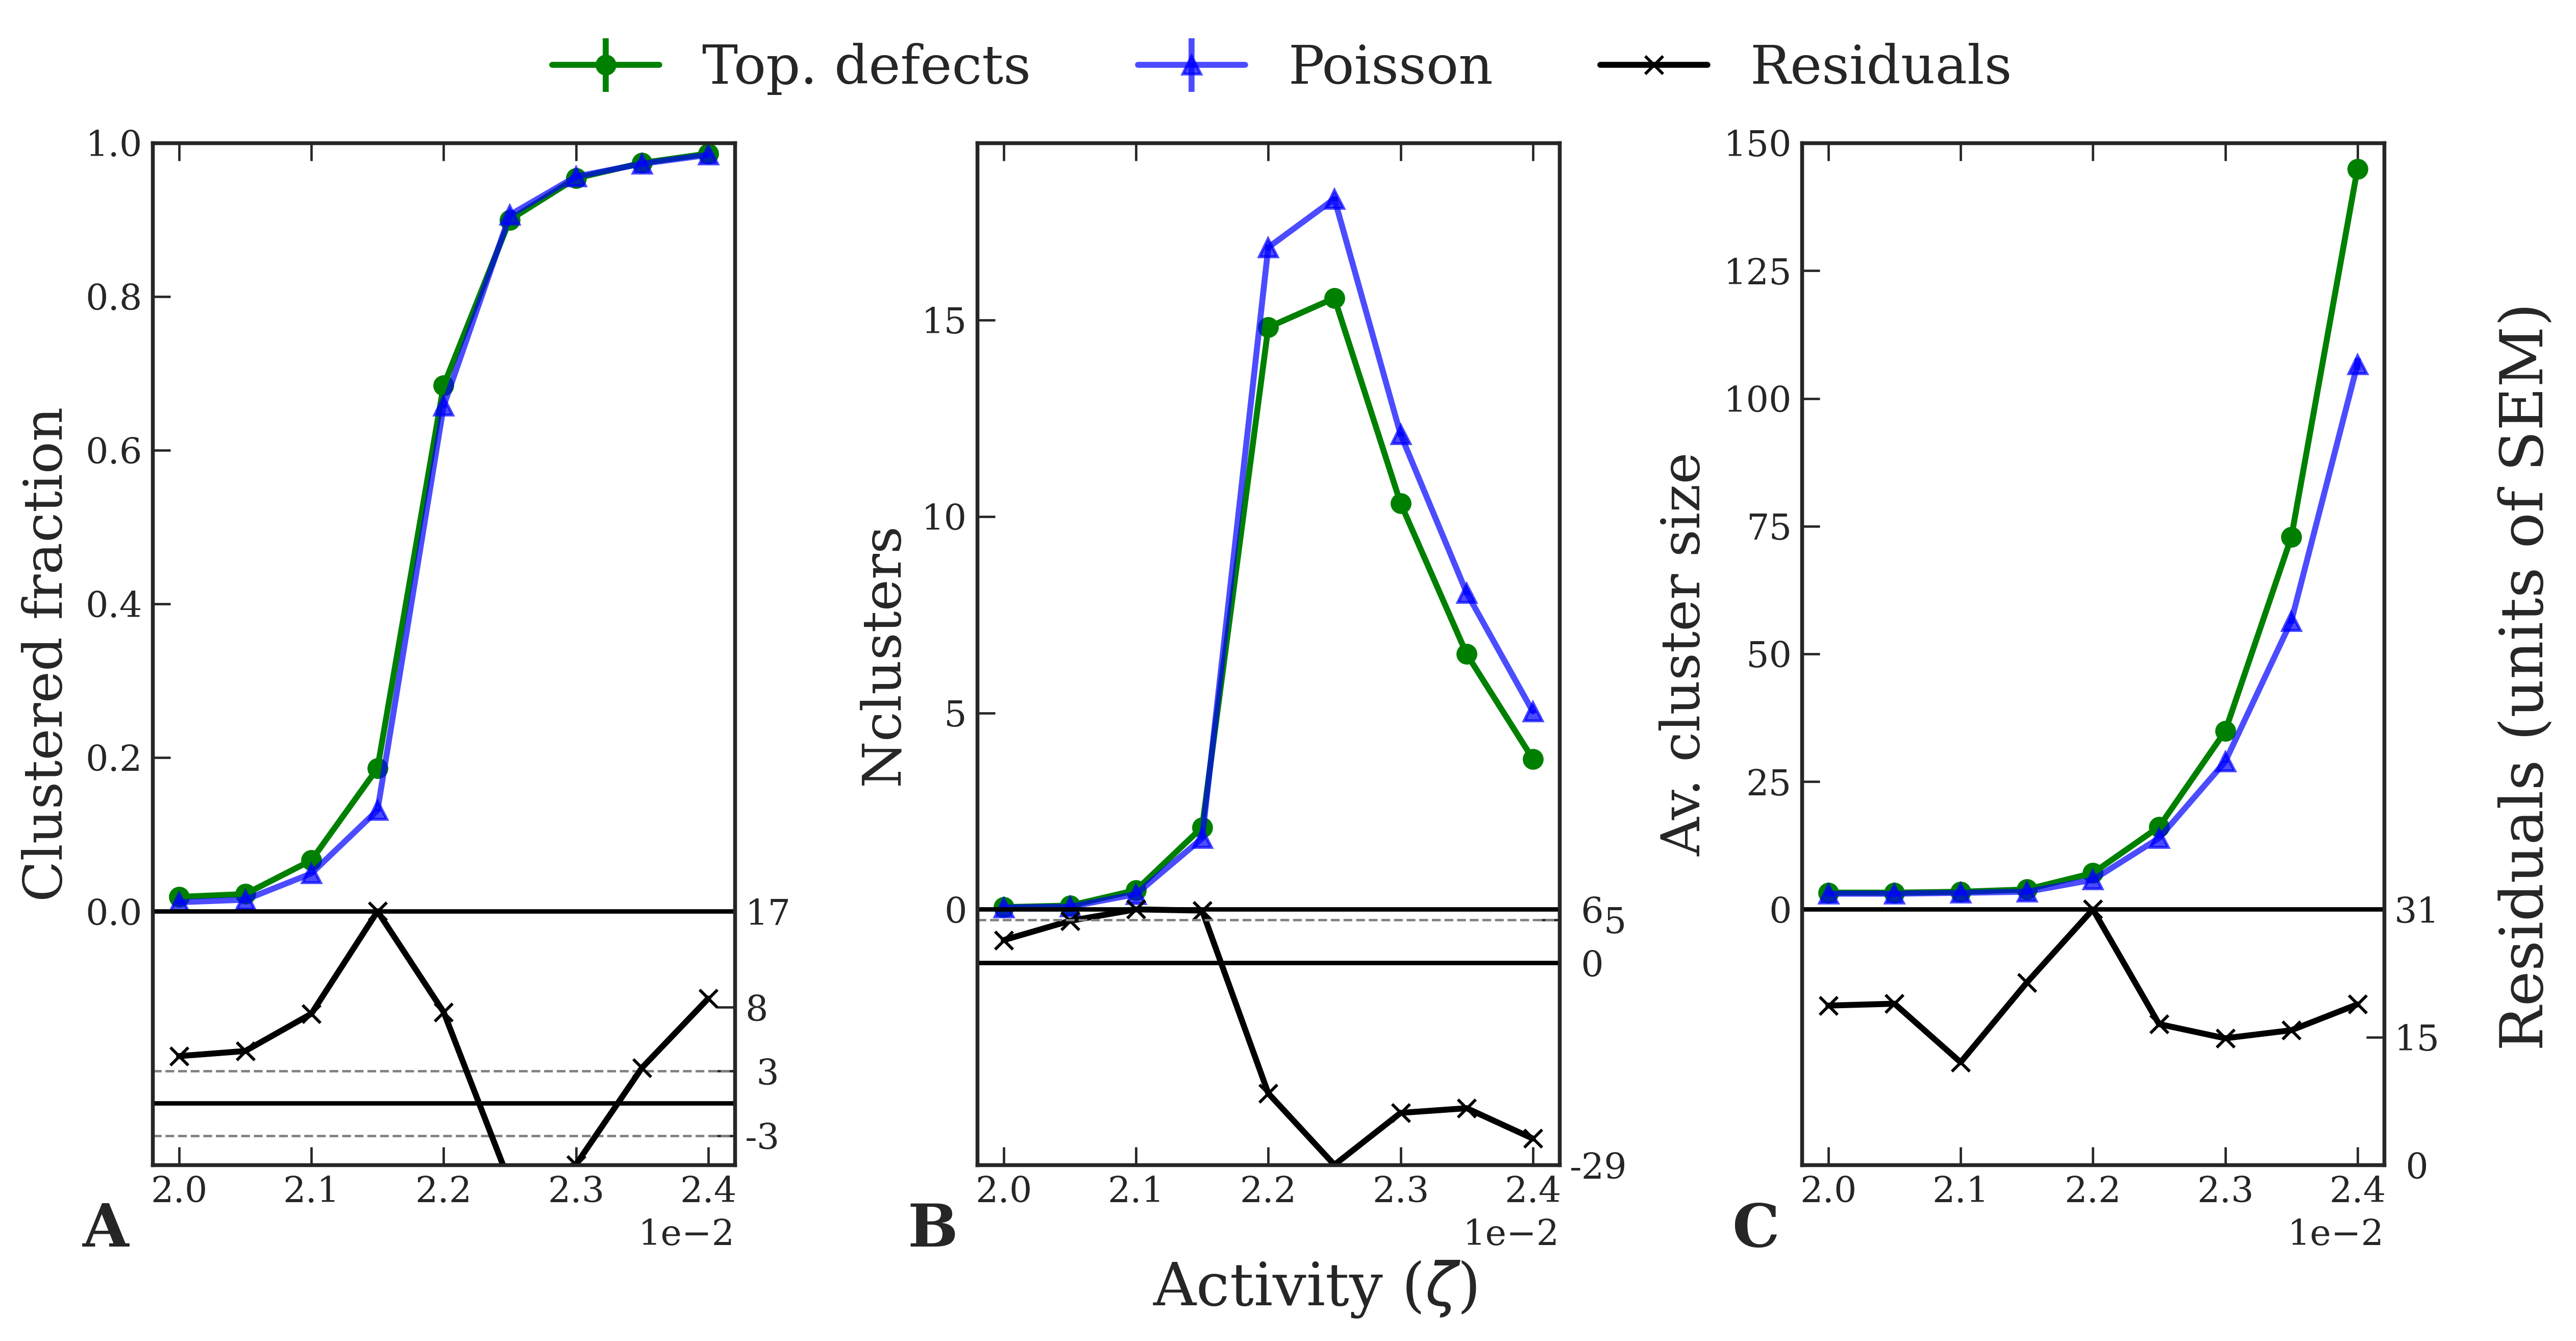

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6)) 

min_act_idx = 1

X = act_list[min_act_idx:]
Y = cl_mean[1:4, min_act_idx:].astype(np.float64)
dY = cl_std[1:4, min_act_idx:].astype(np.float64)

# take care of altered errors due to truncation
for i, act in enumerate(act_list[min_act_idx:]):
    if act in act_vl:
        dY[:, i] *= np.sqrt(1500) / np.sqrt(Nframes_vl)

Y_uni = cl_mean_uni[1:4, min_act_idx:]
dY_uni = cl_std_uni[1:4, min_act_idx:]

Ydif = Y - Y_uni
Ydif_err = np.sqrt(dY**2 + dY_uni**2)
res_arr = Ydif / Ydif_err

for i in range(3):

    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()


    ax[i].errorbar(X, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(X, Y_uni[i], yerr=dY_uni[i], fmt='^-', color = 'blue', **kwargs_dict_uni, alpha=0.7)


    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    # set activity limits
    axinn_xlims = [1.98e-2, 2.42e-2]
    axinn_xticks = np.linspace(axinn_xlims[0]+2e-4, axinn_xlims[1] - 2e-4,5)
    ax[i].set(xticks=axinn_xticks, xlim=axinn_xlims)
    
    axx0 = ax[i].twinx()
    res_norm = res_arr[i]
    res_max = np.nanmax(np.abs(res_norm))


    if i == 0:
        bottom = -.33
        res_zero = -.25
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero)
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, 1)
        ax[i].set(yticks=np.linspace(0,1,6), yticklabels=np.round(np.linspace(0,1, 6),1))
        
        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero - shift * show_std_lines_for/res_max, res_zero + shift * show_std_lines_for/res_max, res_zero + shift/2, top],\
                         [-show_std_lines_for,f' {show_std_lines_for}', int(np.max(res_norm) / 2), int(np.max(res_norm))])
        axx0.set_ylim((bottom, 1))

        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero - shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-', label='Residuals')

    if i == 1:
        ax[i].set(yticks=np.linspace(0,15,4), yticklabels=np.linspace(0,15,4).astype('int'))

        res_max_signed = np.nanmax(res_norm)
        res_min_signed = np.nanmin(res_norm) 

        res_range = np.abs(res_max_signed - res_min_signed)
  
        bottom = -6.5
        res_zero = min(np.abs(res_max_signed), np.abs(res_min_signed)) / max(np.abs(res_max_signed), np.abs(res_min_signed)) * bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + bottom) 
        show_std_lines_for = 5

        ax[i].set_ylim(bottom, - 3*bottom)

        # normalize res_norm by biggest value
        res_norm_unit = res_norm * (shift / res_range) 
        res_norm_unit -= np.abs(res_max_signed) * (shift / res_range)

        axx0.set_yticks([bottom, res_zero, res_zero + shift * show_std_lines_for/res_max, top],\
                         [f'{int(res_min_signed)}', ' 0',  f'   {show_std_lines_for}', f' {int(res_max_signed)}'],)
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')


    if i == 2:

        ax[i].set(yticks=np.linspace(0,150,7), yticklabels=np.linspace(0,150,7).astype('int'))

        bottom = -50
        res_zero = bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero) 
        show_std_lines_for = 5

        ax[i].set_ylim(bottom, - 3*bottom)

        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero, res_zero + shift/2, top],\
                         [' 0',f'{int(np.max(res_norm) / 2)}', f'{int(np.max(res_norm))}'])
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')
        
for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.08, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')

fig.legend(loc = 'upper right', ncol=3, bbox_to_anchor=(0.84, 1.08), fontsize = 18)
fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55, fontsize=20)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55, fontsize=20)
fig.tight_layout()
# set yscale to log
#ax[0].set_yscale('log')




p-value that cum_dist of data is shifted towards higher values than data_uni:  3.047474457628607e-14
Mean of data:  0.6843642737210139 +/ 0.006524252863249784
Mean of data_uni:  0.6578158385689785 +/ 0.002359107211107258

p-value that cum_dist of data is shifted towards higher values than data_uni:  1.5220094500564945e-154
Mean of data:  14.809733333333334 +/ 0.21496955741747087
Mean of data_uni:  16.84375 +/ 0.07904442415263967

p-value that cum_dist of data is shifted towards higher values than data_uni:  7.176552592484306e-213
Mean of data:  7.109835342217665 +/ 0.10692524434801413
Mean of data_uni:  5.792864822738611 +/ 0.02382233644066536


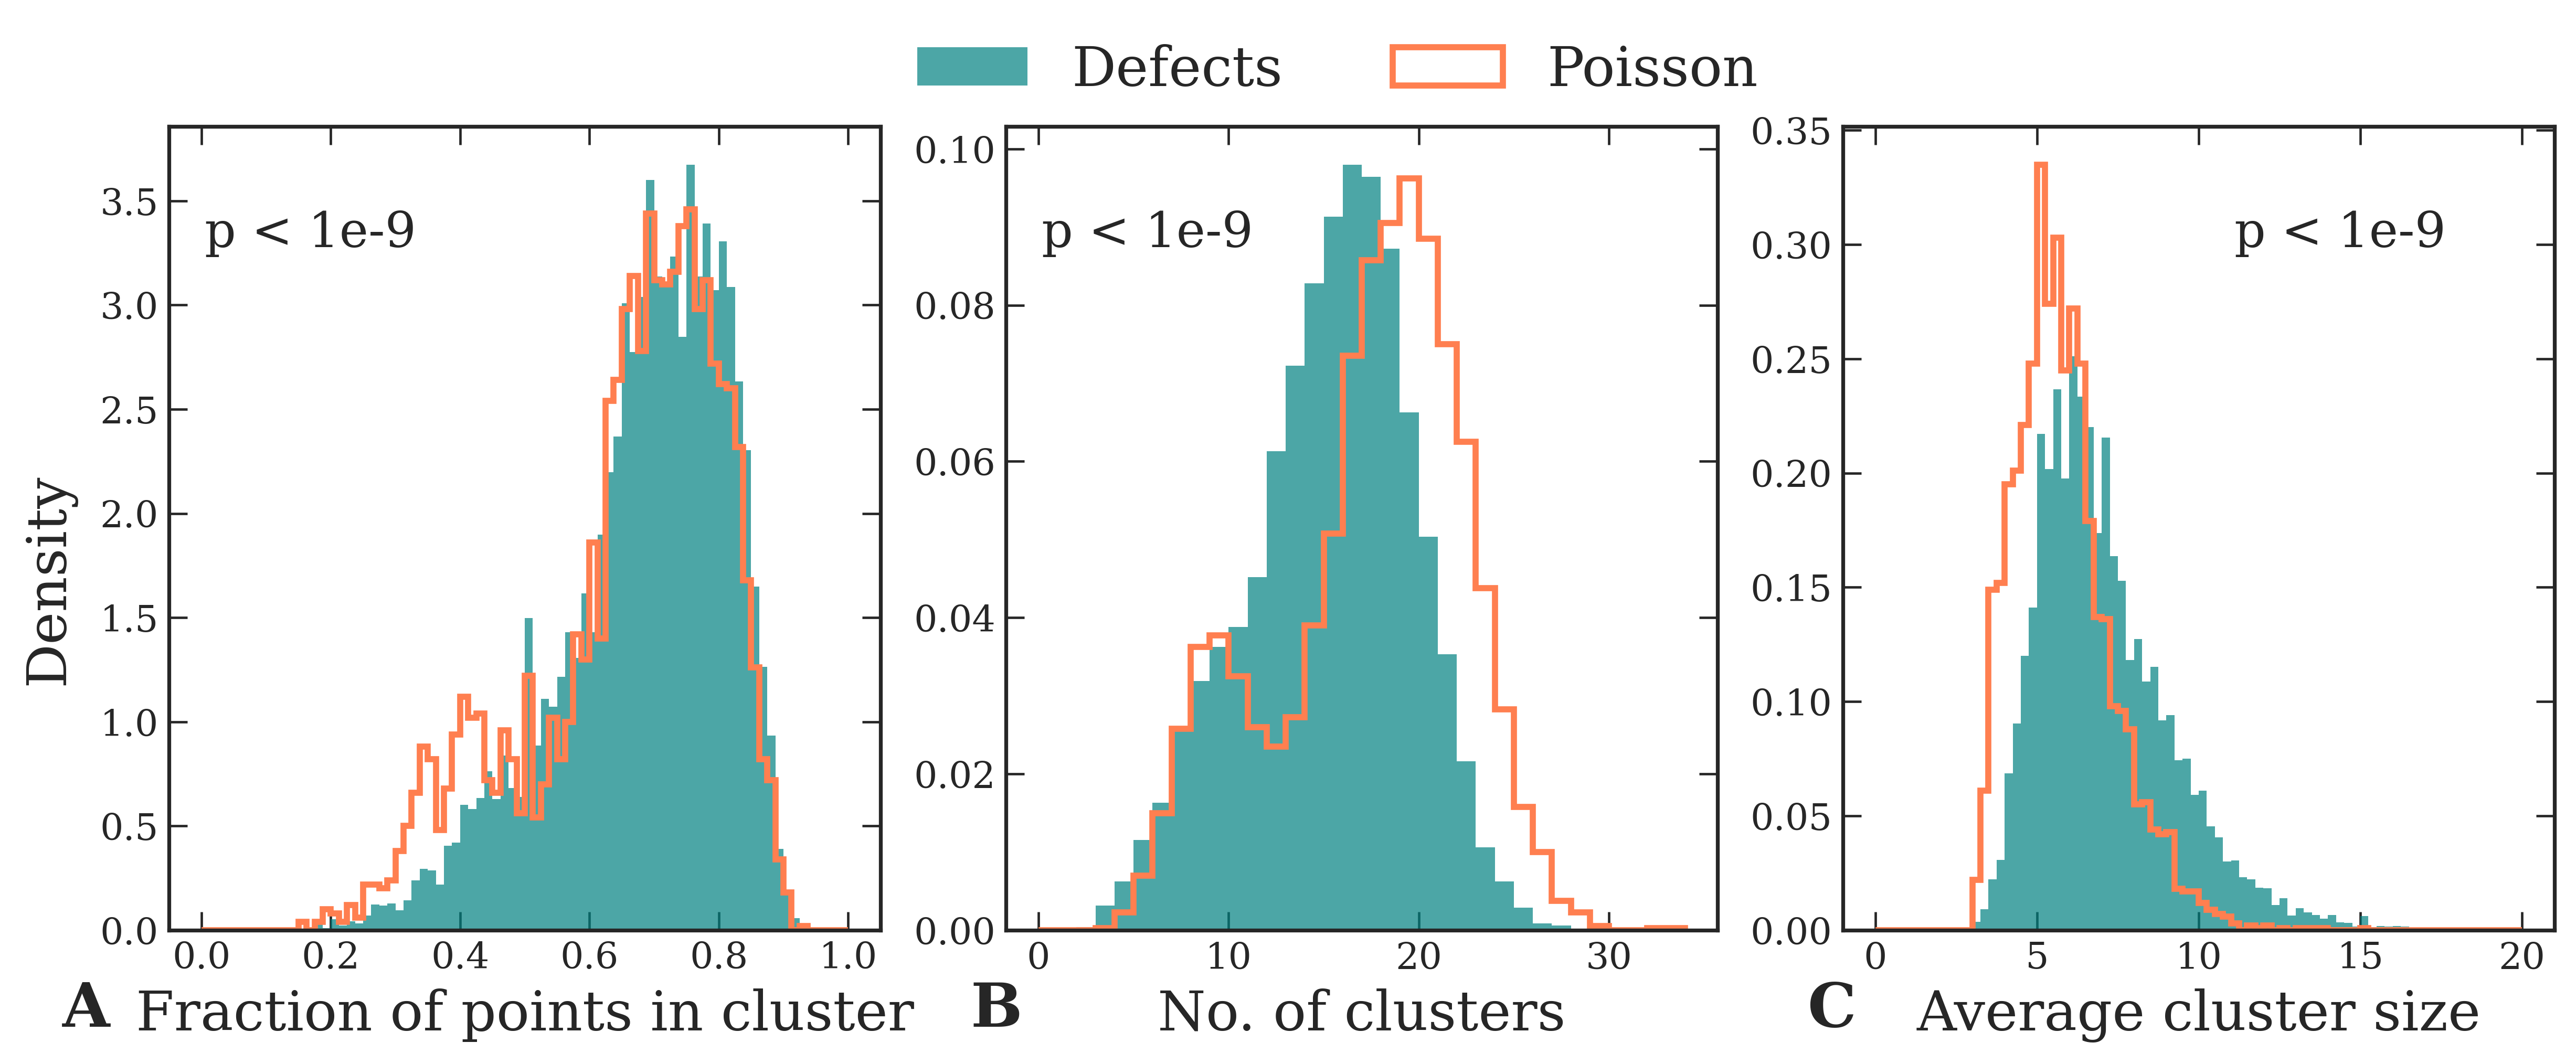

In [27]:


#cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
#cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]
act = 0.022
act_idx = act_vl.index(act)
act_idx_uni = list(act_list).index(act)

fig, ax = plt.subplots(ncols=3, figsize=(12,4.5))
ax = ax.flatten()
title_list = ['Fraction of points in cluster', 'No. of clusters', 'Average cluster size']
range_list = [(0, 1), (0, 34), (0, 20)]
nbins_list = [80, range_list[1][1] - range_list[1][0], 80]
nbins = 100
for i, axx in enumerate(ax):

   # data = cl_arr_vl[:, i + 1, :, :]
    data = cl_arr_vl_orig[:, i + 1, :, :]
    data_uni = cl_arr_uni[i + 1, :, :]
  
    ## Examine combatibility with Kolmogrov test under the null hypothesis that the cumulative distribution of data_uni if shifted
    # towards larger values than data (so that Cum(data(x)) <= Cum(data_uni(x))). Alt. hypothesis: Cum(data(x)) > Cum(data_uni(x))
    _, p_val = stats.ks_2samp(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), alternative = 'two-sided')

    print('\np-value that cum_dist of data is shifted towards higher values than data_uni: ', p_val)


    # Use t-test to calculate p_value under the null hypothesis that the 2 means are equal, letting the alternative hypothesis be that the mean of the drug group
    # is greater than that of the control group
    #t_val, p_val = stats.ttest_ind(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), equal_var = False, alternative = 'greater')
   # print("t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test)", t_val, p_val)

    x_legend = 0.05 if i < 2 else 0.55
    y_legend = 0.85
    if p_val < 1e-9:
        pval_to_print = 'p < 1e-9'
    elif p_val > 0.99:
        pval_to_print = f'p = {p_val:.4f}'
    else:
        pval_to_print = f'p = {p_val:.2f}'

    axx.text(x_legend, y_legend, rf'{pval_to_print}', fontsize=16, transform=axx.transAxes)

    density = True
    
    label = 'Defects' if i == 0 else None
    label_uni = 'Poisson' if i == 0 else None   

    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], \
            histtype='stepfilled', alpha=.7, label = label, density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], \
            histtype='step', alpha=1, label = label_uni, density=density, color='coral')#, edgecolor='orange')

    #axx.vlines(np.mean(data[:, act_idx, :]), 0, 0.2, color='teal', linestyle='-', lw=2)
    #axx.vlines(np.mean(data_uni[act_idx_uni, :]), 0, .2, color='coral', linestyle='-', lw=2)
    print('Mean of data: ', np.mean(data[:, act_idx, :]), '+/', np.std(data[:, act_idx, :], ddof=1) / np.sqrt(Nframes_vl)   )
    print('Mean of data_uni: ', np.mean(data_uni[act_idx_uni, :]), '+/', np.std(data_uni[act_idx_uni, :], ddof=1) / np.sqrt(Ntrial)  )

    axx.set_xlabel(xlabel = title_list[i])
    #axx.legend()

for n, axx in enumerate(ax):
    x_pos = -.15 if n == 0 else -.05
    ax[n].text(x_pos, -.12, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')

fig.legend(ncol=2, bbox_to_anchor=(0.705, 1.09), fontsize=18)
fig.supylabel(t = 'Density', x=0.03);
#fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})');
fig.tight_layout()  
